In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import zipfile
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
zip_file = zipfile.ZipFile(file = "./data/mask_model.zip",mode = "r")
zip_file.extractall()
zip_file.close()

In [4]:
ls

01- Data_Preparation&Preprocessing.ipynb
02- Predictions&Application.ipynb
__pycache__/
data/
images/
mask_model/
models/


In [5]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = "relu",padding = "same", input_shape = (100,100,3)))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = "relu",padding = "same"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units = 192,activation = "relu"))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Dense(units = 28,activation = "relu"))
model.add(tf.keras.layers.Dropout(rate = 0.3))

model.add(tf.keras.layers.Dense(units = 4,activation = "sigmoid"))

In [6]:
#load_model = tf.keras.models.model_from_json(load_model_json)
model.load_weights("./data/mask_model_50.h5")
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

In [7]:
data = np.load("./data/data_preprocess.npz")
print(data.files)

X = data["arr_0"]
y = data["arr_1"]
print(X.shape,y.shape)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

onehot = OneHotEncoder()
y_onehot = onehot.fit_transform(y.reshape(-1,1))
y_array = y_onehot.toarray()

X_train,X_test,y_train,y_test = train_test_split(X,y_array,test_size = .2,random_state = 42)
print(X_test.shape,y_test.shape)

['arr_0', 'arr_1']
(9959, 100, 100, 3) (9959,)
(1992, 100, 100, 3) (1992, 4)


In [8]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred[:5]

array([1, 0, 2, 1, 2])

In [9]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

print("Confusion Matrix : ")
print(confusion_matrix(np.argmax(y_test,axis = 1), y_pred))
print()

print("Classification Reports : ")
print(classification_report(np.argmax(y_test,axis=1),
                y_pred))
print()
print("Accuracy Score : ")
print(accuracy_score(np.argmax(y_test,axis=1),
                y_pred))

Confusion Matrix : 
[[498   1   2   0]
 [  0 532   2   0]
 [  0   1 446   3]
 [  3   1 114 389]]

Classification Reports : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       501
           1       0.99      1.00      1.00       534
           2       0.79      0.99      0.88       450
           3       0.99      0.77      0.87       507

    accuracy                           0.94      1992
   macro avg       0.94      0.94      0.93      1992
weighted avg       0.95      0.94      0.94      1992


Accuracy Score : 
0.9362449799196787


In [10]:
print(onehot.categories_)

[array(['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth'],
      dtype='<U15')]


In [11]:
labels = ['Mask', 'No Mask', 'Covered Mouth Chin', 'Covered Nose Mouth']

def getColor(label):
    
    if label == "Mask":
        color = (0,255,0)
    elif label == "No Mask":
        color = (0,0,255)
    elif label == "Covered Mouth Chin":
        color = (0,255,255)
    else:
        color = (255,255,0)
    return color

In [12]:
getColor("Covered Nose Chin")

(255, 255, 0)

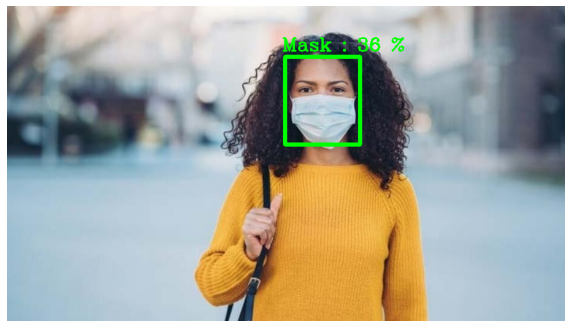

In [14]:
# face detection
face_detection_model = cv2.dnn.readNetFromCaffe("./models/deploy.prototxt.txt",
                                                "./models/res10_300x300_ssd_iter_140000_fp16.caffemodel")

img = cv2.imread("./data/women-wearing-mask.jpg")

def face_mask_prediction(img):
    
    image = img.copy()
    h,w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True)

    face_detection_model.setInput(blob)
    detection = face_detection_model.forward()

    for i in range(0,detection.shape[2]):    
        confidence = detection[0,0,i,2]
        if confidence > 0.5:
            bbox = detection[0,0,i,3:7]*np.array([w,h,w,h])
            bbox = bbox.astype(int)

            pt1 = (bbox[0],bbox[1])
            pt2 = (bbox[2],bbox[3])

            #cv2.rectangle(image,pt1,pt2,(0,255,0),5)

            face = image[bbox[1]:bbox[3], bbox[0] : bbox[2]]
            face_blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
            face_blob_squeeze = np.squeeze(face_blob).T
            face_blob_rotate = cv2.rotate(face_blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
            face_blob_flip = cv2.flip(face_blob_rotate,1)

            img_norm = np.maximum(face_blob_flip,0) / face_blob_flip.max()
            img_input = img_norm.reshape(1,100,100,3)
            result = model.predict(img_input)
            result = softmax(result)[0]
            confidence_index = result.argmax()
            confidence_score = result[confidence_index]

            label = labels[confidence_index]
            label_text = "{} : {:,.0f} %".format(label,confidence_score*100)

            color = getColor(label)
            cv2.rectangle(image,pt1,pt2,color,5)
            cv2.putText(image,label_text,(pt1[0] - 5, pt1[1] - 10),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
            
    return image
               
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(face_mask_prediction(img),cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [14]:
import cv2
import time

cap = cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,720)

pTime=0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps

while True:
    
    conn,frame = cap.read()
    frame = cv2.flip(frame,1)
    
    if conn == False:
        break
        
    image = face_mask_prediction(frame)
    fps_ = fps() 
    cv2.putText(image,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Face Mask Prediction", image)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()

In [20]:
# MediaPipe
import cv2
import numpy as np
import mediapipe as mp
import math
import time
from scipy.special import softmax

class FaceDetector:
    
    def __init__(self,minDetection = 0.5,modelSelection = 0):
        self.minDetection = minDetection
        self.modelSelection = modelSelection
        
        self.mpDraw = mp.solutions.drawing_utils
        self.mpFace = mp.solutions.face_detection
        
        self.Face = self.mpFace.FaceDetection(self.minDetection,self.modelSelection)
        
    def findFaces(self,image,draw = True,color = (0,255,0)):
        
        imageRGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        self.results = self.Face.process(imageRGB)
        h,w,c = image.shape
        bboxs = []
        #print(self.results)
        
        if self.results.detections:
            #print(self.results.detections)
            for id,detection in enumerate(self.results.detections):
                bboxC = detection.location_data.relative_bounding_box
                bbox = int(bboxC.xmin*w),int(bboxC.ymin*h),int(bboxC.width*w),int(bboxC.height*h)
                bboxs.append([id,bbox,detection.score])
                
                if draw:
                    
                    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2]+bbox[0],bbox[3]+bbox[1]),color,2)
                    cv2.putText(image,f"Face Score : {int(detection.score[0]*100)}%",(bbox[0]-10,bbox[1]-20),
                               cv2.FONT_HERSHEY_PLAIN,2,color,2)
                    
        return image,bboxs
    
    def fancyDraw(self,image,bbox,length = 50, thickness = 10, color = (0,255,0)):
        
        x,y,w,h = bbox
        x1,y1 = x+w,y+h
        
        # Top Left
        cv2.line(image,(x,y),(x+length,y),color,thickness)
        cv2.line(image,(x,y),(x,y+length),color,thickness)
        
        # Top Right
        cv2.line(image,(x1,y),(x1-length,y),color,thickness)
        cv2.line(image,(x1,y),(x1,y+length),color,thickness)
        
        # Bottom Left
        cv2.line(image,(x,y1),(x+length,y1),color,thickness)
        cv2.line(image,(x,y1),(x,y1-length),color,thickness)
        
        # Bottom Right
        cv2.line(image,(x1,y1),(x1-length,y1),color,thickness)
        cv2.line(image,(x1,y1),(x1,y1-length),color,thickness)
        
        return image
    
def main():
    
    cap = cv2.VideoCapture(0)
    face_detector = FaceDetector()
    color = (0,255,0)
    while True:
        conn,frame = cap.read()
        frame = cv2.flip(frame,1)
        image,bboxs = face_detector.findFaces(frame,draw=True,color = color)

        if bboxs:
            #bboxs = [[0, (550, 278, 231, 231), [0.9854575395584106]]]
            info = bboxs[0]
            id = info[0]
            bbox = info[1]
            score = info[2]
            frame = face_detector.fancyDraw(frame,bbox,length = 50, thickness = 10, color = color )

            x,y,w,h = bbox
            face = frame[y:y+h,x:x+w]
            
            try:
                face_blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB = True)
                face_blob_squeeze = np.squeeze(face_blob).T
                face_blob_rotate = cv2.rotate(face_blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
                face_blob_flip = cv2.flip(face_blob_rotate,1)

                img_norm = np.maximum(face_blob_flip,0) / face_blob_flip.max()
                img_input = img_norm.reshape(1,100,100,3)
                result = model.predict(img_input)
                result = softmax(result)[0]
                confidence_index = result.argmax()
                confidence_score = result[confidence_index]

                label = labels[confidence_index]
                label_text = "{} : {:,.0f} %".format(label,confidence_score*100)
                color = getColor(label)
                cv2.putText(frame,label_text,(x-10,y-50),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
            
            except:    
                pass

        
        fps_ = fps()
        cv2.putText(frame,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),2)
        cv2.imshow("Face",frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
            
    cap.release()
    cv2.destroyAllWindows()
    
if __name__== "__main__":
    
    pTime = 0
    def fps():
        global pTime
        cTime = time.time()
        fps = 1/(cTime-pTime)
        pTime = cTime
        return fps
    
    labels = ['Mask', 'No Mask', 'Covered Mouth Chin', 'Covered Nose Mouth']
    def getColor(label):

        if label == "Mask":
            color = (0,255,0)
        elif label == "No Mask":
            color = (0,0,255)
        elif label == "Covered Mouth Chin":
            color = (0,255,255)
        else:
            color = (255,255,0)
        return color

    main()


In [ ]:
from PyQt5 import QtWidgets as qtw
from PyQt5 import QtGui as qtg
from PyQt5 import QtCore as qtc
import sys
import  numpy as np
import cv2
import time

class VideoCapture(qtc.QThread):
    change_pixmap_signal = qtc.pyqtSignal(np.ndarray)
    def __init__(self):
        super().__init__()
        self.run_flag = True

    def run(self):
        cap = cv2.VideoCapture(0)
            
        while self.run_flag:
            conn, frame  = cap.read()
            frame = cv2.flip(frame,1)
            predict_img = face_mask_prediction(frame)
                
            if conn:
                self.change_pixmap_signal.emit(predict_img)
            
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
            
        cap.release()
        cv2.destroyAllWindows()

    def stop(self):
        self.run_flag = False
        self.wait()

class mainWindow(qtw.QWidget):
    def __init__(self):
        super().__init__()

        self.setWindowIcon(qtg.QIcon("./images/icon.png"))
        self.setWindowTitle("Face Mask Recognation Software")
        self.setFixedSize(600,600)

        label = qtw.QLabel("<h2>Face Mask Recognation Applicaiton</h2>")
        self.cameraButton = qtw.QPushButton("Open Camera",clicked = self.cameraButtonClick,checkable = True)

        # Screen
        self.screen = qtw.QLabel()
        self.img = qtg.QPixmap(600,480)
        self.img.fill(qtg.QColor("darkGrey"))
        self.screen.setPixmap(self.img)

        # Layout
        layout = qtw.QVBoxLayout()
        layout.addWidget(label)
        layout.addWidget(self.cameraButton)
        layout.addWidget(self.screen)

        self.setLayout(layout)
        self.show()

    def cameraButtonClick(self):
        # Return True False
        status = self.cameraButton.isChecked()
        if status:
            self.cameraButton.setText("Close Camera")
            
            # YUKARDAKI CLASS
            self.capture = VideoCapture()
            self.capture.change_pixmap_signal.connect(self.updateImage)
            self.capture.start()

        elif status == False:
            self.cameraButton.setText("Open Camera")
            self.capture.stop()

    @qtc.pyqtSlot(np.ndarray)
    def updateImage(self,image_array):
        rbg_image = cv2.cvtColor(image_array,cv2.COLOR_BGR2RGB)
        h,w,c = rbg_image.shape
        bytes_per_line = c*w

        convertedImage = qtg.QImage(rbg_image.data,w,h,bytes_per_line,qtg.QImage.Format_RGB888)
        scaledImage = convertedImage.scaled(600,480,qtc.Qt.KeepAspectRatio)
        qt_img = qtg.QPixmap.fromImage(scaledImage)

        #update to screen
        self.screen.setPixmap(qt_img)


if __name__ == "__main__":
    app = qtw.QApplication(sys.argv)
    mw = mainWindow()
    sys.exit(app.exec())